# BE/Bi 103, Fall 2018: Homework 9
## Due 1pm, December 11

(c) 2018 Justin Bois. With the exception of pasted graphics, where the source is noted, this work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

This document was prepared at [Caltech](http://www.caltech.edu) with financial support from the [Donna and Benjamin M. Rosen Bioengineering Center](http://rosen.caltech.edu).

<img src="caltech_rosen.png">

*This homework was generated from an Jupyter notebook.  You can download the notebook [here](hw9.ipynb).*

<br />

## Problem 9.1: Caulobacter growth: exponential or linear, 80 pts

Remind yourself about [Homework 4.2](../hw4.html#Problem-4.2:-Caulobacter-growth,-60-pts), in which you computed the growth and division events of *Caulobacter crescentus* over time using date from [this paper](https://doi.org/10.1073/pnas.1403232111). In this problem, you will use your results from the image processing of those data sets to perform parameter estimation of the growth rates of the individual mother cells and also determine if bacterial growth on a single cell level is linear or exponential. You should use your own results form homework 4 for this problem, but in the event that you had trouble getting those results, you can use [these results](../data/hw_4.2_caulobacter_growth_image_processing_results.csv) from the HW4 solutions.

We know that under ideal conditions, bacterial cells experience exponential growth in bulk. That is, the number of cells grows exponentially. This is possible regardless of how individual cells growth; the repeated divisions lead to exponential growth. In their paper, the authors argue that the growth rate of *each* cell is also exponential.  I.e.,

\begin{align}
a(t) = a_0 \mathrm{e}^{k t},
\end{align}

where $a(t)$ is the area of the cell in the image as a function of time and $a_0$ is the area of the cell right after a division has been completed, which we mark as $t = 0$.

As an alternative model, the authors consider a linear growth model, in which

\begin{align}
a(t) = a_0 + b t.
\end{align}

An exponential curve is approximately linear (with $b = a_0k$) for short time scales.  So, it is often difficult to distinguish between a linear and an exponential growth. Your goal is to perform parameter estimates and do an effective comparison between these two models for growth. You should use hierarchical models, and be sure to take a principled approach in your model construction and evaluation.

Since you are using a hierarchical model, here are a few tips for building and implementing the models. You do not need to take this advice if you do not want to, but I have found that these strategies help.

1. Think carefully about your hyperpriors. If you choose an uninformative hyperprior for a level of the model that is data poor, you end up underpooling. For example, in this problem, there are only two mother cells. So, there are only two *Caulobacter* samples in your data set. If you put a broad prior on the growth rate of *Caulobacter* cells, these two cells can be effectively decoupled.
2. The hierarchical structure can make things difficult to code up and make it harder to hunt down bugs. As I'm building my hierarchical model, often approach it with "baby steps." I like to start off with a non-hierarchical model, often with a subset of the data. I perform sampling on this simpler model, taking a small number of samples so I do not have to wait for too long. After making sure everything is ok with this simpler structure, I then add a level to the hierarchy. I again do the sampling with a subset of the data, make sure everything works ok, and then add the next level of hierarchy, and so on. I find this helps me find bugs and little details along the way.
3. You will probably encounter the funnel of hell, so you should strongly consider using noncentered parametrizations.
4. When you sample out of the full hierarchical model, the sampler may be slower than you are used to seeing. It will likely also be much slower than sampling out of the non-hierarchical model, even though there are only a few more parameters. Stan may also be particularly slow during the warmup phase. You may see it progress taking a few seconds per iteration. This is natural.
5. Finally, just to give you a sense of what kind of computation time you might expect, for my hierarchical model, it took many hours to do the sampling on a c5.xlarge instance on AWS.


In [1]:
import glob
import os
import sys

import numpy as np
import pandas as pd
import scipy.signal

# Import Altair for high level plotting
import altair as alt
import altair_catplot as altcat

# Pevent bulky altair plots
alt.data_transformers.enable('json')

import bebi103
import bokeh
from bokeh.palettes import all_palettes
import itertools
from bokeh.models import Legend, LegendItem
bokeh.io.output_notebook()

Loading BokehJS ...

Let's load up the datasets from 4.2 and check their structure. 

In [2]:
# Data for bacteria 1
df_bac1 = pd.read_csv("./bac_1_areas.csv")
df_bac1 = df_bac1.drop(["Unnamed: 0"], axis = 1)

# Data for bacteria 2
df_bac2 = pd.read_csv("./bac_2_areas.csv")
df_bac2 = df_bac2.drop(["Unnamed: 0"], axis = 1)
df_bac1.head()

,label,area (sq µm)
0,0,976
1,1,552
2,2,551
3,3,568
4,4,554


We graph the area over time to get a sense of it.

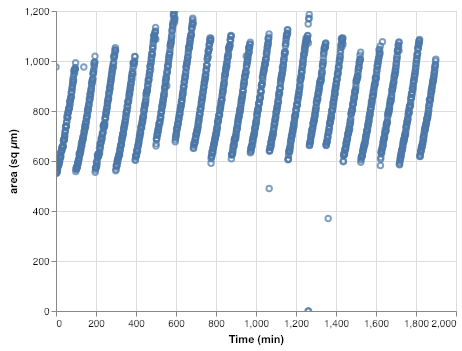

In [3]:
alt.Chart(df_bac1).mark_point().encode(
    x=alt.X('label', title = "Time (min)"),
    y=alt.Y('area (sq µm)', scale=alt.Scale(zero=False)),
).interactive()

And now for bacteria 2:

In [4]:
df_bac2.head()

,label,area (sq µm)
0,0,1046
1,1,435
2,2,606
3,3,610
4,4,632


And graph:

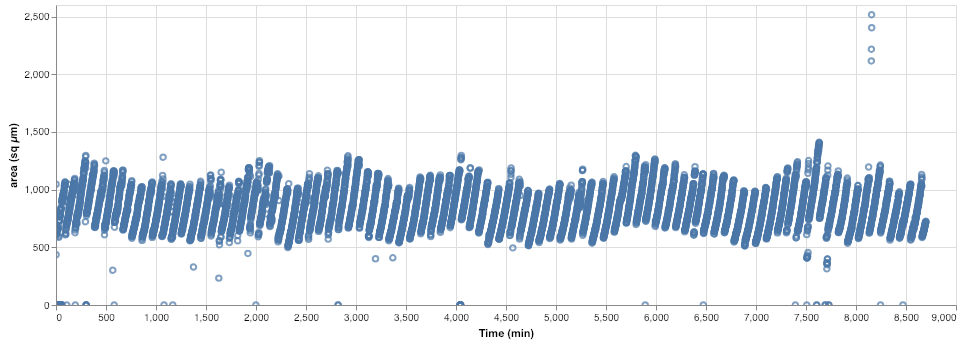

In [5]:
alt.Chart(df_bac2).mark_point().encode(
    x=alt.X('label', title = "Time (min)"),
    y=alt.Y('area (sq µm)', scale=alt.Scale(zero=False)),
).interactive().properties(height=300,
                           width=900)

Remove unphysical outliers:

In [6]:
df_bac1["isOutlier"] = ((df_bac1['area (sq µm)'] < 500) | # Drop low-area outliers
                        (df_bac1['area (sq µm)'] > 1500)) # Drop high-area outliers

df_bac2["isOutlier"] = ((df_bac2['area (sq µm)'] < 500) | # Drop low-area outliers
                        (df_bac2['area (sq µm)'] > 1500)) # Drop high-area outliers

bac1_thresh = df_bac1[df_bac1["isOutlier"] == False]
bac2_thresh = df_bac2[df_bac2["isOutlier"] == False]

Importing functions from 4.2

In [7]:
def find_divisions(df):
    """Returns an array that contains whether each point in a dataframe is a division or not."""
    # I will start by identifying the first division. 
    # We can see from the plots that this occurs in the first 30 frames. 
    areas = df['area (sq µm)'].values
    isDivision = np.zeros(len(df.index), dtype = bool)
    div_1 = np.argmin(areas[:30])
    isDivision[div_1] = True
    for i in range(30, len(df.index) - 30):
        region = np.zeros(61)
        for j in range(0, 61):
            region[j] = areas[i - 30 + j] # samples the 10 points on either 
                                         # side of the point of interest.
        if ((np.argmin(region) == 30) and region[30] < 780):
            isDivision[i] = True
    return isDivision

Create "isDivision" columns:

In [8]:
bac1_thresh.loc[:,"isDivision"] = find_divisions(bac1_thresh.copy())
bac2_thresh.loc[:,"isDivision"] = find_divisions(bac2_thresh.copy())

/Users/jaredlivingston/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/jaredlivingston/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


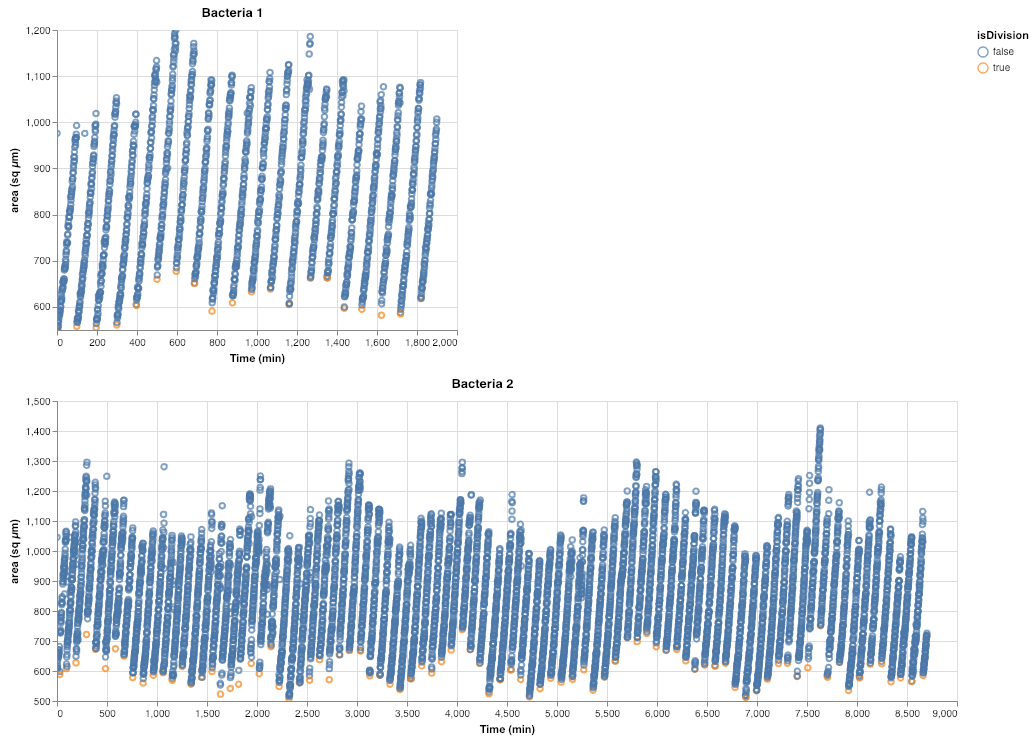

In [9]:
plot1 = alt.Chart(bac1_thresh).mark_point().encode(
            x=alt.X('label', title = "Time (min)"),
            y=alt.Y('area (sq µm)', scale=alt.Scale(zero=False)),
            color = 'isDivision:N',
        ).interactive().properties(title = "Bacteria 1")

plot2 = alt.Chart(bac2_thresh).mark_point().encode(
            x=alt.X('label', title = "Time (min)"),
            y=alt.Y('area (sq µm)', scale=alt.Scale(zero=False)),
            color = 'isDivision:N',
        ).interactive().properties(height=300,
                                   width=900,
                                   title = "Bacteria 2")

plot1 & plot2

I am curious how clean this data really is. I will try to color code the plot based on division number. 

In [10]:
bac1_thresh.head()

,label,area (sq µm),isOutlier,isDivision
0,0,976,False,False
1,1,552,False,False
2,2,551,False,True
3,3,568,False,False
4,4,554,False,False


In [11]:
def get_div_num(df):
    is_div = df["isDivision"].values
    div_num = np.zeros(len(is_div))
    for i in range(0, len(is_div)):
        div_num[i] = np.sum(is_div[:i + 1])
    return div_num
bac1_thresh.loc[:,"div_num"] = get_div_num(bac1_thresh.copy())
bac2_thresh.loc[:,"div_num"] = get_div_num(bac2_thresh.copy())

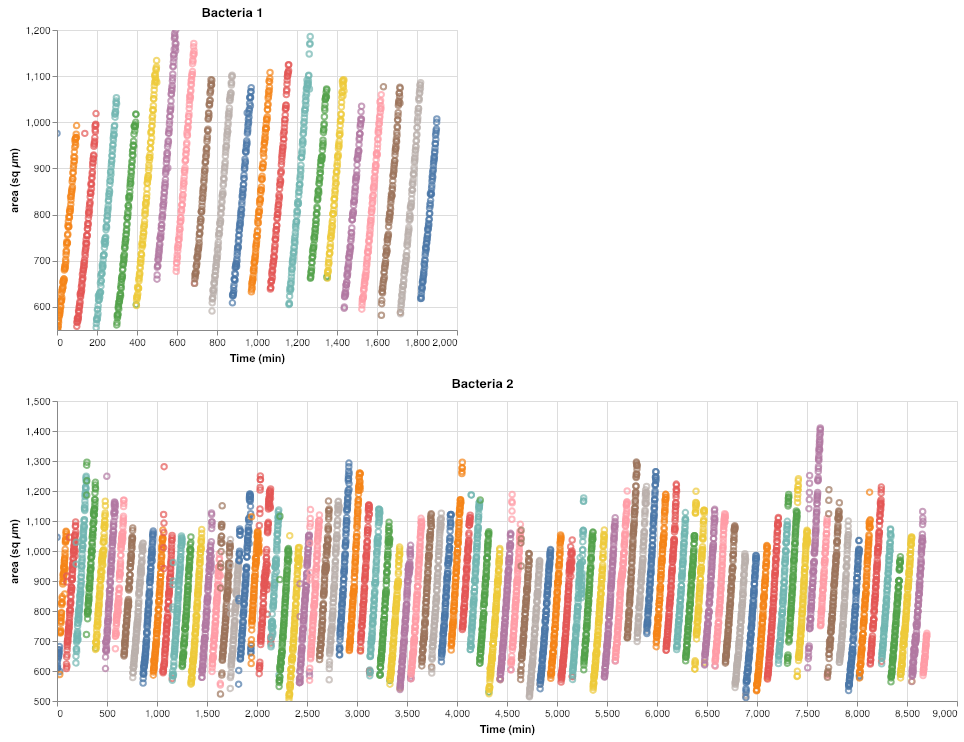

In [12]:
plot1 = alt.Chart(bac1_thresh).mark_point().encode(
            x=alt.X('label', title = "Time (min)"),
            y=alt.Y('area (sq µm)', scale=alt.Scale(zero=False)),
            color = alt.Color('div_num:N',legend=None),
        ).interactive().properties(title = "Bacteria 1")

plot2 = alt.Chart(bac2_thresh).mark_point().encode(
            x=alt.X('label', title = "Time (min)"),
            y=alt.Y('area (sq µm)', scale=alt.Scale(zero=False)),
            color = alt.Color('div_num:N',legend=None),
        ).interactive().properties(height=300,
                                   width=900,
                                   title = "Bacteria 2")
plot1 & plot2

The first bacterium's lineages look beautiful, but the first lineage is only two points, so I'll delete it. The first two lineages for the second bacteria look like one lineage; I'll trim some points off it and merge the lineages. 

In [13]:
# Remove lineage one for bac 1
bac1_thresh.loc[:,"div_num"] = bac1_thresh.copy()["div_num"].values - 1
bac1_thresh = bac1_thresh[bac1_thresh["div_num"] >= 0]

# Merge lineage and trim for bac 2
bac2_thresh = bac2_thresh[1:]
div_num = bac2_thresh["div_num"].values
for i in range(0, len(div_num)):
    if div_num[i] == 0:
        div_num[i] = 1
div_num = div_num - 1
bac2_thresh.loc[:,"div_num"] = div_num

The second bacterium's growth also looks good, with some errors near the cell divisions. We know we got the start correct, so this noise is probably because the image processing has trouble differentiating whether the cell has actually divided in the region about the division. These errors all occur above 950, so I'll just set any point near (but past) a division that is above that threshold to belong to the previous lineage. Furthermore, there are similar errors near the beginnings of divisions. If a point is in the last ten points in a lineage and is below 700, it should be in the next lineage. 

In [14]:
is_div = bac2_thresh["isDivision"].values
div_num = bac2_thresh["div_num"].values
areas = bac2_thresh['area (sq µm)'].values
for i in range(0, len(bac2_thresh.index)):
    if is_div[i] == True:
        for j in range(0, 30):
            if areas[j + i] > 950:
                div_num[j + i] = div_num[j + i] - 1
        if div_num[i] > 1:
            for j in range(-10, 0):
                if areas[j + i] < 700:
                    div_num[j + i] = div_num[j + i] + 1
bac2_thresh.loc[:,"div_num"] = div_num



In [15]:
# Manually delete errors in image segmentation
bac1_thresh = bac1_thresh.drop([139, 1632])

Let's re-make the plot and see if we solved the problems!

In [16]:
bac1_thresh.head()

,label,area (sq µm),isOutlier,isDivision,div_num
2,2,551,False,True,0.0
3,3,568,False,False,0.0
4,4,554,False,False,0.0
5,5,559,False,False,0.0
6,6,558,False,False,0.0


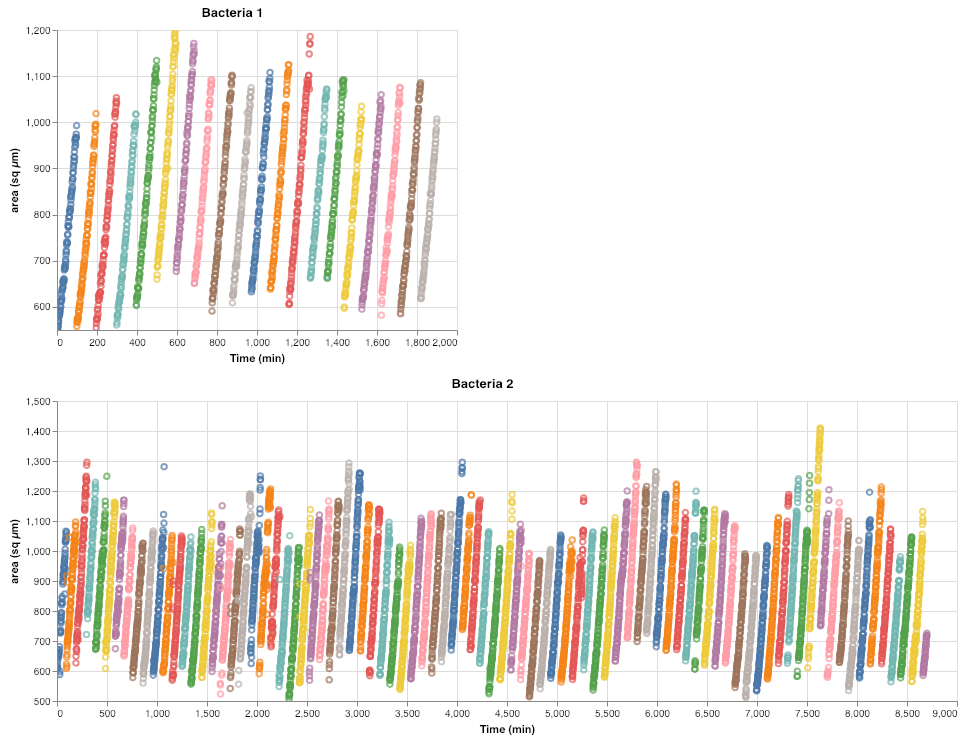

In [17]:
plot1 = alt.Chart(bac1_thresh).mark_point().encode(
            x=alt.X('label', title = "Time (min)"),
            y=alt.Y('area (sq µm)', scale=alt.Scale(zero=False)),
            color = alt.Color('div_num:N',legend=None),
            tooltip = ["label", "isDivision", 'area (sq µm)']
        ).interactive().properties(title = "Bacteria 1")

plot2 = alt.Chart(bac2_thresh).mark_point().encode(
            x=alt.X('label', title = "Time (min)"),
            y=alt.Y('area (sq µm)', scale=alt.Scale(zero=False)),
            color = alt.Color('div_num:N',legend=None),
            tooltip = ["label", "isDivision", 'area (sq µm)', 'div_num']
        ).interactive().properties(height=300,
                                   width=900,
                                   title = "Bacteria 2")
plot1 & plot2

Yay! Now the data looks ready for modeling